In [1]:
import tensorflow as tf
import os #Navigate through file structures


In [2]:
tf.config.experimental.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
# Avoiding Out of Memory Error by setting and limiting  GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Removing any dodgy images
import cv2 #Computer vision
import imghdr #Enables checking of different file extensions

C:\Users\PC\AppData\Local\Temp\ipykernel_236\1788175113.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr #Enables checking of different file extensions


In [5]:
#To check the folders present
os.listdir(r'C:\Users\PC\Documents\Data-Science-Tasks\Malaria-ImageCLassification\cell_images')

['Parasitized', 'Uninfected']

In [7]:
tf.data.Dataset.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None) -> 'DatasetV2'>

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)
Source:   
@keras_export(
    [
        "keras.utils.image_dataset_from_directory",
        "keras.preprocessing.image_dataset_from_directory",
    ]
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    ve

In [10]:
#Building an image dataset
data = tf.keras.utils.image_dataset_from_directory(r'C:\Users\PC\Documents\Data-Science-Tasks\Malaria-ImageCLassification\cell_images')

Found 27558 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x0000021657A27980>)

In [13]:
#Gets another batch from the iterator
batch = data_iterator.next()
len(batch)

2

In [14]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [15]:
# Class 0 equals Parasatized
# Class 1 equals Uninfected
batch[1].max

<function ndarray.max>

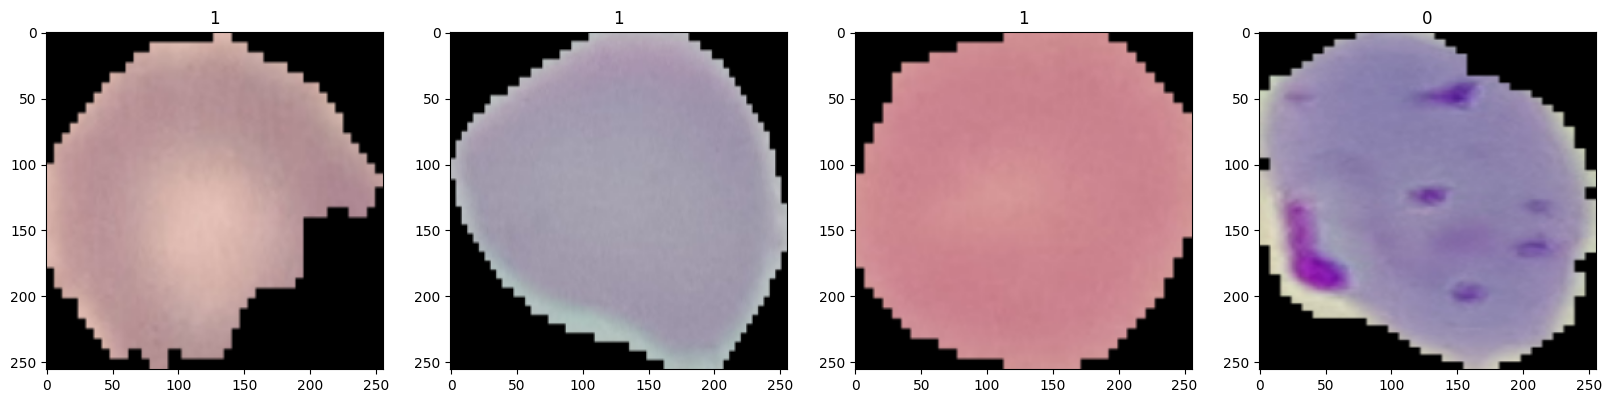

In [16]:
#Using matplotlib to plot out 4 images at the same time
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Pre processing Data

This section will involve scaling the image values to between 0 and 1 instead of 25,500 images.
This will help the Deep Learning Models generalize faster and produce better results.
Also, I will split the data into three sections to endure we dont overfit:
1. Training
2. Testing
3. Validation

In [17]:
# Scaling the Data
data = data.map(lambda x, y: (x/255, y))


In [18]:
scaled_iterator = data.as_numpy_iterator()

In [19]:
#The images are between 0 and 1
scaled_iterator.next()[1].max()

1

In [20]:
#862 Batches and each batch has 32 images. 862 * 32 = 27584 images
len(data)

862

In [21]:
#Establishing training data sizes, allocating data to each of the partitions
# Ratio of 80%, 10%, 10%

train_size = int(len(data)*.8)
val_size = int(len(data)*.1)
test_size = int(len(data)*.1)+1

In [22]:
train_size + val_size + test_size

862

In [23]:
train = data.take(train_size) 
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [24]:
len(train)

689

In [25]:
len(val)

86

In [26]:
len(test)

87

# Deep Model

Deep modelling using the Keras sequential model API 
Build a deep learning model

In [27]:
from tensorflow.keras.models import Sequential #deep learning classification
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout 

In [28]:
model = Sequential()

In [29]:
#
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

Training the data

In [32]:
logdir='logs'

In [33]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
#The deep model training
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 888s 1s/step - accuracy: 0.7157 - loss: 0.5467 - val_accuracy: 0.9335 - val_loss: 0.1926
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 945s 1s/step - accuracy: 0.9359 - loss: 0.1965 - val_accuracy: 0.9400 - val_loss: 0.1866
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 796s 1s/step - accuracy: 0.9459 - loss: 0.1574 - val_accuracy: 0.9433 - val_loss: 0.1591
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 567s 823ms/step - accuracy: 0.9518 - loss: 0.1382 - val_accuracy: 0.9459 - val_loss: 0.1959
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 569s 826ms/step - accuracy: 0.9626 - loss: 0.1065 - val_accuracy: 0.9179 - val_loss: 0.2951
Epoch 6/20
 48/689 ━━━━━━━━━━━━━━━━━━━━ 7:43 723ms/step - accuracy: 0.9462 - loss: 0.1450

KeyboardInterrupt: 

In [35]:
hist.history

NameError: name 'hist' is not defined

Plot Perfomance

In [36]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [37]:
# Accuracy metrics
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

# Evaluate Performance

Evaluation

In [38]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [39]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [40]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [122]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy}')

Precision:0.9402984976768494, Recall:0.9611650705337524, Accuracy:<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.94778824>>


Testing the data

ValueError: <module 'cv2' from 'c:\\Python312\\Lib\\site-packages\\cv2\\__init__.py'> is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

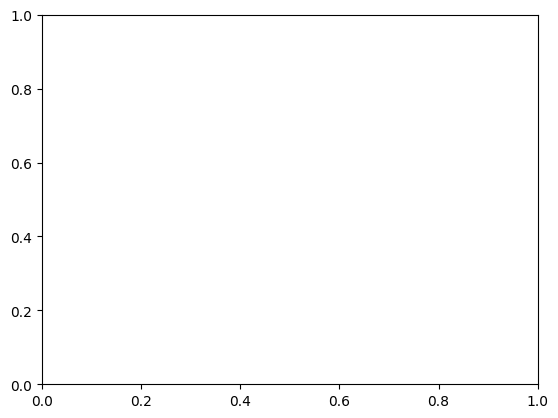

In [125]:
#use the cv2
img = cv2.imread('uninfectedsmear.jpg')
plt.imshow(img, cv2)
plt.show()

In [ ]:
resize_image = tf.image.resize(img, (256, 256))
plt.imshow(resize_image.numpy().astype(int))
plt.show()

In [ ]:
np.expand_dims(resize_image, 0)

In [ ]:
#Predict whether a pap smear is Uninfected or Parasitized.
# 1 = Uninfected and 0 = Parasitized
yhat = model.predict(np.expand_dims(resize_image/255, 0))
yhat

In [ ]:
if yhat > 0.5:
    print(f'Predicted class is Uninfected')
else:
    print(f'Predicted class is Parasitized')

# Save the Model

Saving the model, that I may be able to reload it at a future date

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','malariapapsmear.h5'))

In [ ]:
new_model = load_model(os.path.join('models','malariapapsmear.h5'))

In [ ]:
yhat_new=new_model.predict(np.expand_dims(resize_image/255, 0))

In [ ]:
if yhat_new > 0.5:
    print(f'Predicted class is Uninfected')
else:
    print(f'Predicted class is Parasitized')